# Gesture Recognition
In this group project, you are going to build a 3D Conv model that will be able to predict the 5 gestures correctly. Please import the following libraries to get started.

In [ ]:
import numpy as np
import os
import imageio.v2 as imageio
from skimage.transform import resize
import datetime
import os
import warnings
warnings.filterwarnings('ignore')

We set the random seed so that the results don't vary drastically.

In [ ]:
np.random.seed(100)
import random as rn
rn.seed(100)
from keras import backend as K
import tensorflow as tf
tf.random.set_seed(100)

In this block, you read the folder names for training and validation. You also set the `batch_size` here. Note that you set the batch size in such a way that you are able to use the GPU in full capacity. You keep increasing the batch size until the machine throws an error.

In [ ]:
!gdown "1ehyrYBQ5rbQQe6yL4XbLWe3FMvuVUGiL&confirm=t"

Downloading...
From: https://drive.google.com/uc?id=1ehyrYBQ5rbQQe6yL4XbLWe3FMvuVUGiL&confirm=t
To: /content/Project_data.zip
100% 1.71G/1.71G [00:11<00:00, 144MB/s]


In [ ]:
%%capture
!unzip Project_data.zip

In [ ]:
train_doc = np.random.permutation(open('/content/Project_data/train.csv').readlines())
val_doc = np.random.permutation(open('/content/Project_data/val.csv').readlines())




## Generator
This is one of the most important part of the code. The overall structure of the generator has been given. In the generator, you are going to preprocess the images as you have images of 2 different dimensions as well as create a batch of video frames. You have to experiment with `img_idx`, `y`,`z` and normalization such that you get high accuracy.

In [ ]:
def generator(source_path, folder_list, batch_size, img_h, img_w, sequence_index):
    print( 'Source path = ', source_path, '; batch size =', batch_size)
    img_idx = sequence_index
    num_batches = len(folder_list)//batch_size #number of batches num of folders/batches can be made ignoring remainder
    x = len(img_idx)
    y = img_h
    z = img_w

    while True:
        t = np.random.permutation(folder_list)
        for batch in range(num_batches): # we iterate over the number of batches
            batch_data = np.zeros((batch_size,x,y,z,3)) # x is the number of images you use for each video, (y,z) is the final size of the input images and 3 is the number of channels RGB
            batch_labels = np.zeros((batch_size,5)) # batch_labels is the one hot representation of the output
            for folder in range(batch_size): # iterate over the batch_size
                imgs = os.listdir(source_path+'/'+ t[folder + (batch*batch_size)].split(';')[0]) # read all the images in the folder

                for idx,item in enumerate(img_idx): #  Iterate iver the frames/images of a folder to read them in
                    image = imageio.imread(source_path+'/'+ t[folder + (batch*batch_size)].strip().split(';')[0]+'/'+imgs[item]).astype(np.float32)
                    image = resize(image, [img_h,img_w])


                    #normalize by channel
                    batch_data[folder,idx,:,:,0] = (image[:, : , 0] - np.percentile(image[:, : , 0],2.5))/ (np.percentile(image[:, : , 0],97.5) - np.percentile(image[:, : , 0],2.5))
                    batch_data[folder,idx,:,:,1] = (image[:, : , 1] - np.percentile(image[:, : , 1],2.5))/ (np.percentile(image[:, : , 1],97.5) - np.percentile(image[:, : , 1],2.5))
                    batch_data[folder,idx,:,:,2] = (image[:, : , 2] - np.percentile(image[:, : , 2],2.5))/ (np.percentile(image[:, : , 2],97.5) - np.percentile(image[:, : , 2],2.5))

                batch_labels[folder, int(t[folder + (batch*batch_size)].strip().split(';')[2])] = 1
            yield batch_data, batch_labels


        # write the code for the remaining data points which are left after full batches
        if len(folder_list) != batch_size*num_batches:
            num_remaining_folders = len(folder_list) - (batch_size*num_batches) #total length of folder list minus complete batch length
            batch_data = np.zeros((num_remaining_folders,x,y,z,3))
            batch_labels = np.zeros((num_remaining_folders,5))

            for folder in range(num_remaining_folders): # iterate over the batch_size
                imgs = os.listdir(source_path+'/'+ t[folder + (batch*batch_size)].split(';')[0]) # read all the images in the folder

                for idx,item in enumerate(img_idx): #  Iterate iver the frames/images of a folder to read them in
                    image = imageio.imread(source_path+'/'+ t[folder + (batch*batch_size)].strip().split(';')[0]+'/'+imgs[item]).astype(np.float32)
                    image = resize(image, [img_h,img_w])


                    #normalize by channel
                    batch_data[folder,idx,:,:,0] = (image[:, : , 0] - np.percentile(image[:, : , 0],2.5))/ (np.percentile(image[:, : , 0],97.5) - np.percentile(image[:, : , 0],2.5))
                    batch_data[folder,idx,:,:,1] = (image[:, : , 1] - np.percentile(image[:, : , 1],2.5))/ (np.percentile(image[:, : , 1],97.5) - np.percentile(image[:, : , 1],2.5))
                    batch_data[folder,idx,:,:,2] = (image[:, : , 2] - np.percentile(image[:, : , 2],2.5))/ (np.percentile(image[:, : , 2],97.5) - np.percentile(image[:, : , 2],2.5))

                batch_labels[folder, int(t[folder + (batch*batch_size)].strip().split(';')[2])] = 1
            yield batch_data, batch_labels



Note here that a video is represented above in the generator as (number of images, height, width, number of channels). Take this into consideration while creating the model architecture.

In [ ]:
curr_dt_time = datetime.date.today()
train_path = '/content/Project_data/train'
val_path = '/content/Project_data/val'
num_train_sequences = len(train_doc)
print('# training sequences =', num_train_sequences)
num_val_sequences = len(val_doc)
print('# validation sequences =', num_val_sequences)
num_epochs = 25
print ('# epochs =', num_epochs)

# training sequences = 663
# validation sequences = 100
# epochs = 25


## Model
Here you make the model using different functionalities that Keras provides. Remember to use `Conv3D` and `MaxPooling3D` and not `Conv2D` and `Maxpooling2D` for a 3D convolution model. You would want to use `TimeDistributed` while building a Conv2D + RNN model. Also remember that the last layer is the softmax. Design the network in such a way that the model is able to give good accuracy on the least number of parameters so that it can fit in the memory of the webcam.

In [ ]:

from keras.models import Sequential, Model
from keras.layers import Dense, LSTM, GRU, Flatten, TimeDistributed, Flatten, BatchNormalization, Activation, Dropout
from keras.layers.convolutional import Conv3D, MaxPooling3D, Conv2D, MaxPooling2D
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from keras import optimizers,Input

## 3D CONVOLUTION ARCHITECTURES EXPERIMENTS


Constants for all 3d Conv

- epoachs = 25
- optimiser = SGD(lr=0.01, momentum=0.5)
- max pooling = (3,3,3)


### Batch Size

#### Large Batch Size of 63 - Model 1

Constants
- sequence length = 30
- img size = 120,120,3

In [ ]:
batch_size=63

model1 = Sequential()

model1.add(Conv3D(16, (3,3,3), input_shape = (30,120,120,3), padding='same'))
model1.add(BatchNormalization())
model1.add(Activation('relu'))
model1.add(MaxPooling3D(pool_size=(3,3,3)))


model1.add(Conv3D(32, (3,3,3),padding='same'))
model1.add(BatchNormalization())
model1.add(Activation('relu'))
model1.add(MaxPooling3D(pool_size=(3,3,3)))
model1.add(Dropout(0.3))

model1.add(MaxPooling3D(pool_size=(3,3,3)))

model1.add(Flatten())

model1.add(Dense(512, activation='relu'))
model1.add(Dropout(0.5))


model1.add(Dense(5))
model1.add(Activation('softmax'))



Now that you have written the model, the next step is to `compile` the model. When you print the `summary` of the model, you'll see the total number of parameters you have to train.

In [ ]:
optimiser = optimizers.SGD(learning_rate=0.01, momentum=0.5)
model1.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (model1.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d (Conv3D)             (None, 30, 120, 120, 16)  1312      
                                                                 
 batch_normalization (BatchN  (None, 30, 120, 120, 16)  64       
 ormalization)                                                   
                                                                 
 activation (Activation)     (None, 30, 120, 120, 16)  0         
                                                                 
 max_pooling3d (MaxPooling3D  (None, 10, 40, 40, 16)   0         
 )                                                               
                                                                 
 conv3d_1 (Conv3D)           (None, 10, 40, 40, 32)    13856     
                                                                 
 batch_normalization_1 (Batc  (None, 10, 40, 40, 32)   1

Let us create the `train_generator` and the `val_generator` which will be used in `.fit_generator`.

In [ ]:
img_h=120
img_w = 120
sequence_index=[i for i in range(0,30)]

train_generator = generator(train_path, train_doc, batch_size, img_h, img_w, sequence_index)
val_generator = generator(val_path, val_doc, batch_size, img_h, img_w, sequence_index)

In [ ]:
if not os.path.exists("models"):
    os.mkdir("models")

os.chdir("/content/models")

In [ ]:
model_name = 'model_1_batch63_' + str(curr_dt_time).replace('-','') ## using datetime.date.today()

if not os.path.exists(model_name):

    os.mkdir(model_name)

filepath = model_name+ "/" + model_name + '.h5'
#model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}

checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True, save_weights_only=False, mode='auto')

LR = ReduceLROnPlateau(monitor = 'val_loss',
                      factor=0.3,
                      patience=3,
                      verbose=1)
callbacks_list = [checkpoint, LR]

The `steps_per_epoch` and `validation_steps` are used by `fit_generator` to decide the number of next() calls it need to make.

In [ ]:
if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1

Let us now fit the model. This will start training the model and with the help of the checkpoints, you'll be able to save the model at the end of each epoch.

In [ ]:
model_1 = model1.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1,
                    callbacks=callbacks_list, validation_data=val_generator,
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)


Source path =  /content/Project_data/train ; batch size = 63
Epoch 1/25
11/11 [==============================] - ETA: 0s - loss: 3.5462 - categorical_accuracy: 0.2443 Source path =  /content/Project_data/val ; batch size = 63

Epoch 1: val_loss improved from inf to 1.70516, saving model to model_1_batch63_20230805/model_1_batch63_20230805.h5
11/11 [==============================] - 213s 20s/step - loss: 3.5462 - categorical_accuracy: 0.2443 - val_loss: 1.7052 - val_categorical_accuracy: 0.2000 - lr: 0.0100
Epoch 2/25
11/11 [==============================] - ETA: 0s - loss: 1.5571 - categorical_accuracy: 0.3575 
Epoch 2: val_loss improved from 1.70516 to 1.65635, saving model to model_1_batch63_20230805/model_1_batch63_20230805.h5
11/11 [==============================] - 202s 20s/step - loss: 1.5571 - categorical_accuracy: 0.3575 - val_loss: 1.6564 - val_categorical_accuracy: 0.2100 - lr: 0.0100
Epoch 3/25
11/11 [==============================] - ETA: 0s - loss: 1.4138 - categorical_acc

In [ ]:
import matplotlib.pyplot as plt

def plot_acc(model, epochs):
    acc = model.history['categorical_accuracy']
    val_acc = model.history['val_categorical_accuracy']

    loss = model.history['loss']
    val_loss = model.history['val_loss']

    epochs_range = range(epochs)

    plt.figure(figsize=(8, 8))
    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, acc, label='Training Accuracy')
    plt.plot(epochs_range, val_acc, label='Validation Accuracy')
    plt.legend(loc='lower right')
    plt.title('Training and Validation Accuracy')

    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, loss, label='Training Loss')
    plt.plot(epochs_range, val_loss, label='Validation Loss')
    plt.legend(loc='upper right')
    plt.title('Training and Validation Loss')
    plt.show()

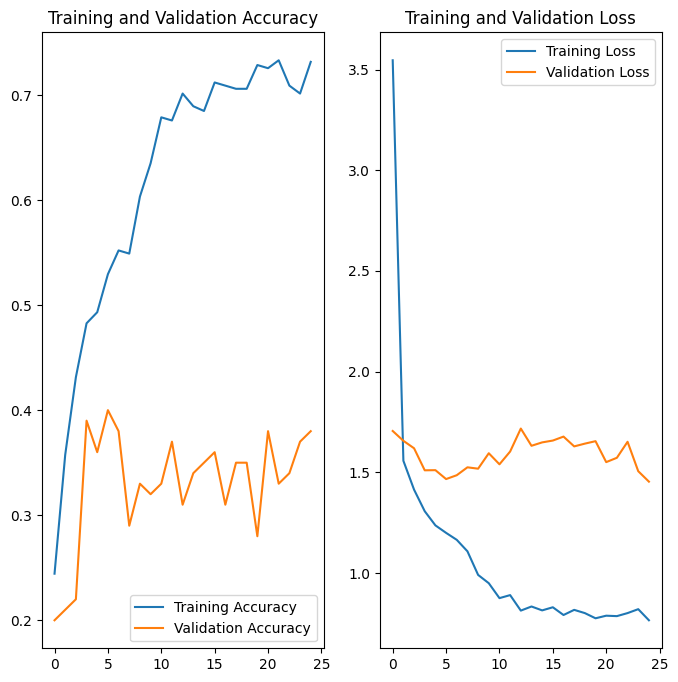

In [ ]:
plot_acc(model_1,num_epochs)

#### **Observations**

Clear overfitting, model does not learn.

#### Small Batch Size of 7 - Model 2

Constants
- sequence length = 30
- img size = 120,120,3


In [ ]:
batch_size = 7

model2 = Sequential()

model2.add(Conv3D(16, (3,3,3), input_shape = (30,120,120,3), padding='same'))
model2.add(BatchNormalization())
model2.add(Activation('relu'))
model2.add(MaxPooling3D(pool_size=(3,3,3)))


model2.add(Conv3D(32, (3,3,3),padding='same'))
model2.add(BatchNormalization())
model2.add(Activation('relu'))
model2.add(MaxPooling3D(pool_size=(3,3,3)))
model2.add(Dropout(0.3))

model2.add(Flatten())

model2.add(Dense(512, activation='relu'))
model2.add(Dropout(0.5))


model2.add(Dense(5))
model2.add(Activation('softmax'))

In [ ]:
optimiser = optimizers.SGD(learning_rate=0.01, momentum=0.5)
model2.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (model2.summary())

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_2 (Conv3D)           (None, 30, 120, 120, 16)  1312      
                                                                 
 batch_normalization_2 (Batc  (None, 30, 120, 120, 16)  64       
 hNormalization)                                                 
                                                                 
 activation_3 (Activation)   (None, 30, 120, 120, 16)  0         
                                                                 
 max_pooling3d_3 (MaxPooling  (None, 10, 40, 40, 16)   0         
 3D)                                                             
                                                                 
 conv3d_3 (Conv3D)           (None, 10, 40, 40, 32)    13856     
                                                                 
 batch_normalization_3 (Batc  (None, 10, 40, 40, 32)  

In [ ]:
img_h=120
img_w = 120
sequence_index=[i for i in range(0,30)]

train_generator = generator(train_path, train_doc, batch_size, img_h, img_w, sequence_index)
val_generator = generator(val_path, val_doc, batch_size, img_h, img_w, sequence_index)

In [ ]:
model_name = 'model_2_batch7_' + str(curr_dt_time).replace('-','')

if not os.path.exists(model_name):

    os.mkdir(model_name)

filepath = model_name +"/" + model_name + '.h5'

checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True, save_weights_only=False, mode='auto')

LR = ReduceLROnPlateau(monitor = 'val_loss',
                      factor=0.3,
                      patience=3,
                      verbose=1)
callbacks_list = [checkpoint, LR]

In [ ]:
if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1

In [ ]:
model_2 = model2.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1,
                    callbacks=callbacks_list, validation_data=val_generator,
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)


Source path =  /content/Project_data/train ; batch size = 7
Epoch 1/25
95/95 [==============================] - ETA: 0s - loss: 4.2571 - categorical_accuracy: 0.2624Source path =  /content/Project_data/val ; batch size = 7

Epoch 1: val_loss improved from inf to 1.60359, saving model to model_2_batch7_20230805/model_2_batch7_20230805.h5
95/95 [==============================] - 208s 2s/step - loss: 4.2571 - categorical_accuracy: 0.2624 - val_loss: 1.6036 - val_categorical_accuracy: 0.2800 - lr: 0.0100
Epoch 2/25
95/95 [==============================] - ETA: 0s - loss: 1.5310 - categorical_accuracy: 0.3122
Epoch 2: val_loss improved from 1.60359 to 1.56619, saving model to model_2_batch7_20230805/model_2_batch7_20230805.h5
95/95 [==============================] - 204s 2s/step - loss: 1.5310 - categorical_accuracy: 0.3122 - val_loss: 1.5662 - val_categorical_accuracy: 0.3200 - lr: 0.0100
Epoch 3/25
95/95 [==============================] - ETA: 0s - loss: 1.4978 - categorical_accuracy: 0.3

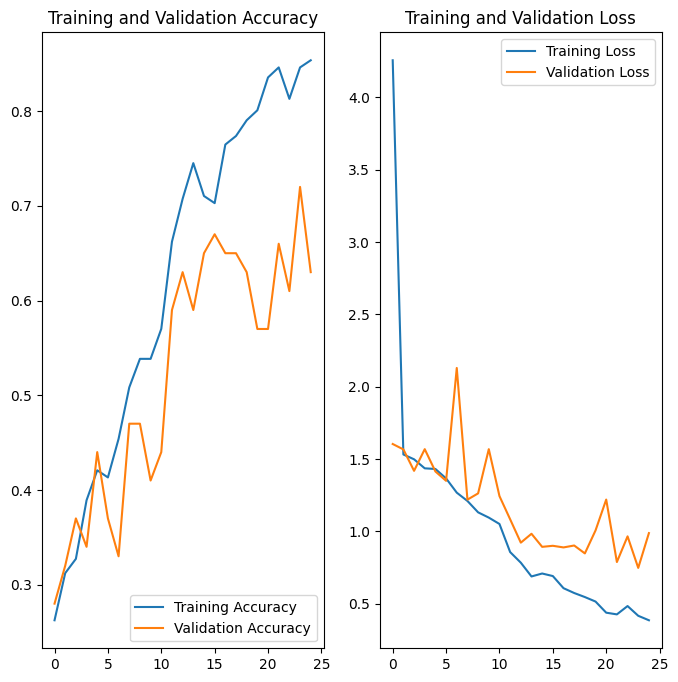

In [ ]:
plot_acc(model_2,num_epochs)

#### Observations
overfitting still occurs but model learns a lot better with smaller batch size. Each step is shorter but the overall time per epoch is essentially the same

### Number of Sequences

#### Sequence length of 15 - Model 3

Constants
- batch_size = 7
- img size = 120,120,3

In [ ]:
batch_size = 7

model3 = Sequential()

model3.add(Conv3D(16, (3,3,3), input_shape = (15,120,120,3), padding='same'))
model3.add(BatchNormalization())
model3.add(Activation('relu'))
model3.add(MaxPooling3D(pool_size=(3,3,3)))


model3.add(Conv3D(32, (3,3,3),padding='same'))
model3.add(BatchNormalization())
model3.add(Activation('relu'))
model3.add(MaxPooling3D(pool_size=(3,3,3)))
model3.add(Dropout(0.3))

model3.add(Flatten())

model3.add(Dense(512, activation='relu'))
model3.add(Dropout(0.5))


model3.add(Dense(5))
model3.add(Activation('softmax'))

In [ ]:
optimiser = optimizers.SGD(learning_rate=0.01, momentum=0.5)
model3.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (model3.summary())

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_4 (Conv3D)           (None, 15, 120, 120, 16)  1312      
                                                                 
 batch_normalization_4 (Batc  (None, 15, 120, 120, 16)  64       
 hNormalization)                                                 
                                                                 
 activation_6 (Activation)   (None, 15, 120, 120, 16)  0         
                                                                 
 max_pooling3d_5 (MaxPooling  (None, 5, 40, 40, 16)    0         
 3D)                                                             
                                                                 
 conv3d_5 (Conv3D)           (None, 5, 40, 40, 32)     13856     
                                                                 
 batch_normalization_5 (Batc  (None, 5, 40, 40, 32)   

In [ ]:
img_h=120
img_w = 120
sequence_index=[i for i in range(0,30,2)]

train_generator = generator(train_path, train_doc, batch_size, img_h, img_w, sequence_index)
val_generator = generator(val_path, val_doc, batch_size, img_h, img_w, sequence_index)

In [ ]:
model_name = 'model_3_seq15_' + str(curr_dt_time).replace('-','')

if not os.path.exists(model_name):

    os.mkdir(model_name)

filepath = model_name +"/" + model_name + '.h5'

checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True, save_weights_only=False, mode='auto')

LR = ReduceLROnPlateau(monitor = 'val_loss',
                      factor=0.3,
                      patience=3,
                      verbose=1)
callbacks_list = [checkpoint, LR]

In [ ]:
if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1

In [ ]:
model_3 = model3.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1,
                    callbacks=callbacks_list, validation_data=val_generator,
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)


Source path =  /content/Project_data/train ; batch size = 7
Epoch 1/25
95/95 [==============================] - ETA: 0s - loss: 2.3618 - categorical_accuracy: 0.3288Source path =  /content/Project_data/val ; batch size = 7

Epoch 1: val_loss improved from inf to 1.34596, saving model to model_3_seq15_20230805/model_3_seq15_20230805.h5
95/95 [==============================] - 102s 1s/step - loss: 2.3618 - categorical_accuracy: 0.3288 - val_loss: 1.3460 - val_categorical_accuracy: 0.4500 - lr: 0.0100
Epoch 2/25
95/95 [==============================] - ETA: 0s - loss: 1.2425 - categorical_accuracy: 0.4917
Epoch 2: val_loss improved from 1.34596 to 1.15319, saving model to model_3_seq15_20230805/model_3_seq15_20230805.h5
95/95 [==============================] - 102s 1s/step - loss: 1.2425 - categorical_accuracy: 0.4917 - val_loss: 1.1532 - val_categorical_accuracy: 0.5200 - lr: 0.0100
Epoch 3/25
95/95 [==============================] - ETA: 0s - loss: 1.1355 - categorical_accuracy: 0.5415


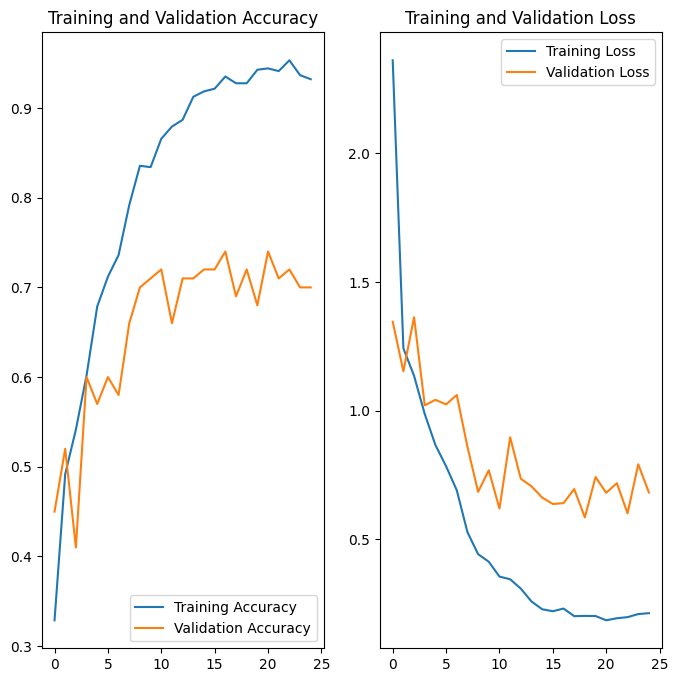

In [ ]:
plot_acc(model_3,num_epochs)

#### Observations

faster training due to fewer images per step

### Resizing Images - Model 4

#### IMG SIZE 160,160

Constants
- sequence length = 15
- batch size = 7


In [ ]:
batch_size = 7

model4 = Sequential()

model4.add(Conv3D(16, (3,3,3), input_shape = (15,160,160,3), padding='same'))
model4.add(BatchNormalization())
model4.add(Activation('relu'))
model4.add(MaxPooling3D(pool_size=(3,3,3)))


model4.add(Conv3D(32, (3,3,3),padding='same'))
model4.add(BatchNormalization())
model4.add(Activation('relu'))
model4.add(MaxPooling3D(pool_size=(3,3,3)))
model4.add(Dropout(0.3))

model4.add(Flatten())

model4.add(Dense(512, activation='relu'))
model4.add(Dropout(0.5))


model4.add(Dense(5))
model4.add(Activation('softmax'))

In [ ]:
optimiser = optimizers.SGD(learning_rate=0.01, momentum=0.5)
model4.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (model4.summary())

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_6 (Conv3D)           (None, 15, 160, 160, 16)  1312      
                                                                 
 batch_normalization_6 (Batc  (None, 15, 160, 160, 16)  64       
 hNormalization)                                                 
                                                                 
 activation_9 (Activation)   (None, 15, 160, 160, 16)  0         
                                                                 
 max_pooling3d_7 (MaxPooling  (None, 5, 53, 53, 16)    0         
 3D)                                                             
                                                                 
 conv3d_7 (Conv3D)           (None, 5, 53, 53, 32)     13856     
                                                                 
 batch_normalization_7 (Batc  (None, 5, 53, 53, 32)   

In [ ]:
img_h=160
img_w = 160
sequence_index=[i for i in range(0,30,2)]

train_generator = generator(train_path, train_doc, batch_size, img_h, img_w, sequence_index)
val_generator = generator(val_path, val_doc, batch_size, img_h, img_w, sequence_index)

In [ ]:
model_name = 'model_4_img160x160_' + str(curr_dt_time).replace('-','')

if not os.path.exists(model_name):

    os.mkdir(model_name)

filepath = model_name +"/" + model_name + '.h5'

checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True, save_weights_only=False, mode='auto')

LR = ReduceLROnPlateau(monitor = 'val_loss',
                      factor=0.3,
                      patience=3,
                      verbose=1)
callbacks_list = [checkpoint, LR]

In [ ]:
if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1

In [ ]:
model_4 = model4.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1,
                    callbacks=callbacks_list, validation_data=val_generator,
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

Source path =  /content/Project_data/train ; batch size = 7
Epoch 1/25
95/95 [==============================] - ETA: 0s - loss: 2.9487 - categorical_accuracy: 0.2926Source path =  /content/Project_data/val ; batch size = 7

Epoch 1: val_loss improved from inf to 1.50359, saving model to model_4_img160x160_20230805/model_4_img160x160_20230805.h5
95/95 [==============================] - 133s 1s/step - loss: 2.9487 - categorical_accuracy: 0.2926 - val_loss: 1.5036 - val_categorical_accuracy: 0.3700 - lr: 0.0100
Epoch 2/25
95/95 [==============================] - ETA: 0s - loss: 1.4211 - categorical_accuracy: 0.3876
Epoch 2: val_loss improved from 1.50359 to 1.34427, saving model to model_4_img160x160_20230805/model_4_img160x160_20230805.h5
95/95 [==============================] - 131s 1s/step - loss: 1.4211 - categorical_accuracy: 0.3876 - val_loss: 1.3443 - val_categorical_accuracy: 0.3800 - lr: 0.0100
Epoch 3/25
95/95 [==============================] - ETA: 0s - loss: 1.2320 - categoric

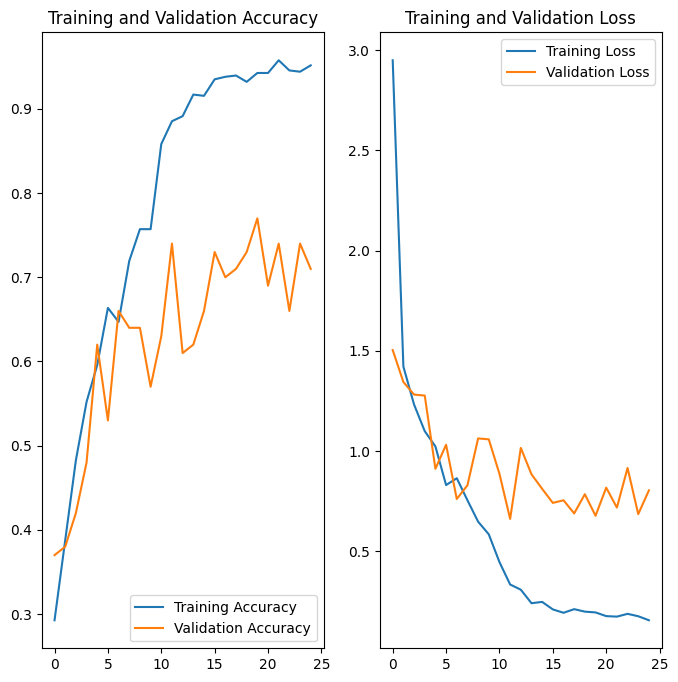

In [ ]:
plot_acc(model_4,num_epochs)

#### **Observations**

worse overfitting than 120x120 with similar cross entropy loss.

### Increasing Conv Depth - Model 5

#### Conv Layers = 3

Constants:
- img_size = 120,120
- sequence length = 15
- batch size = 7

In [ ]:
batch_size = 7

model5 = Sequential()

model5.add(Conv3D(16, (3,3,3), input_shape = (15,120,120,3), padding='same'))
model5.add(BatchNormalization())
model5.add(Activation('relu'))
model5.add(MaxPooling3D(pool_size=(2,2,2)))


model5.add(Conv3D(32, (3,3,3),padding='same'))
model5.add(BatchNormalization())
model5.add(Activation('relu'))
model5.add(MaxPooling3D(pool_size=(2,2,2)))
model5.add(Dropout(0.3))

model5.add(Conv3D(64, (3,3,3),padding='same'))
model5.add(BatchNormalization())
model5.add(Activation('relu'))
model5.add(MaxPooling3D(pool_size=(2,2,2)))

model5.add(Flatten())

model5.add(Dense(512, activation='relu'))
model5.add(Dropout(0.5))


model5.add(Dense(5))
model5.add(Activation('softmax'))

In [ ]:
optimiser = optimizers.SGD(learning_rate=0.01, momentum=0.5)
model5.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (model5.summary())

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_8 (Conv3D)           (None, 15, 120, 120, 16)  1312      
                                                                 
 batch_normalization_8 (Batc  (None, 15, 120, 120, 16)  64       
 hNormalization)                                                 
                                                                 
 activation_12 (Activation)  (None, 15, 120, 120, 16)  0         
                                                                 
 max_pooling3d_9 (MaxPooling  (None, 7, 60, 60, 16)    0         
 3D)                                                             
                                                                 
 conv3d_9 (Conv3D)           (None, 7, 60, 60, 32)     13856     
                                                                 
 batch_normalization_9 (Batc  (None, 7, 60, 60, 32)   

In [ ]:
img_h=120
img_w = 120
sequence_index=[i for i in range(0,30,2)]

train_generator = generator(train_path, train_doc, batch_size, img_h, img_w, sequence_index)
val_generator = generator(val_path, val_doc, batch_size, img_h, img_w, sequence_index)

In [ ]:
model_name = 'model_5_convlayers3_' + str(curr_dt_time).replace('-','')

if not os.path.exists(model_name):

    os.mkdir(model_name)

filepath = model_name +"/" + model_name + '.h5'

checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True, save_weights_only=False, mode='auto')

LR = ReduceLROnPlateau(monitor = 'val_loss',
                      factor=0.3,
                      patience=3,
                      verbose=1)
callbacks_list = [checkpoint, LR]

In [ ]:
if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1

In [ ]:
model_5 = model5.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1,
                    callbacks=callbacks_list, validation_data=val_generator,
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

Source path =  /content/Project_data/train ; batch size = 7
Epoch 1/25
95/95 [==============================] - ETA: 0s - loss: 3.2797 - categorical_accuracy: 0.2926Source path =  /content/Project_data/val ; batch size = 7

Epoch 1: val_loss improved from inf to 1.52216, saving model to model_5_convlayers3_20230805/model_5_convlayers3_20230805.h5
95/95 [==============================] - 102s 1s/step - loss: 3.2797 - categorical_accuracy: 0.2926 - val_loss: 1.5222 - val_categorical_accuracy: 0.2600 - lr: 0.0100
Epoch 2/25
95/95 [==============================] - ETA: 0s - loss: 1.3323 - categorical_accuracy: 0.4253
Epoch 2: val_loss did not improve from 1.52216
95/95 [==============================] - 101s 1s/step - loss: 1.3323 - categorical_accuracy: 0.4253 - val_loss: 1.6163 - val_categorical_accuracy: 0.2300 - lr: 0.0100
Epoch 3/25
95/95 [==============================] - ETA: 0s - loss: 1.2487 - categorical_accuracy: 0.4902
Epoch 3: val_loss did not improve from 1.52216
95/95 [====

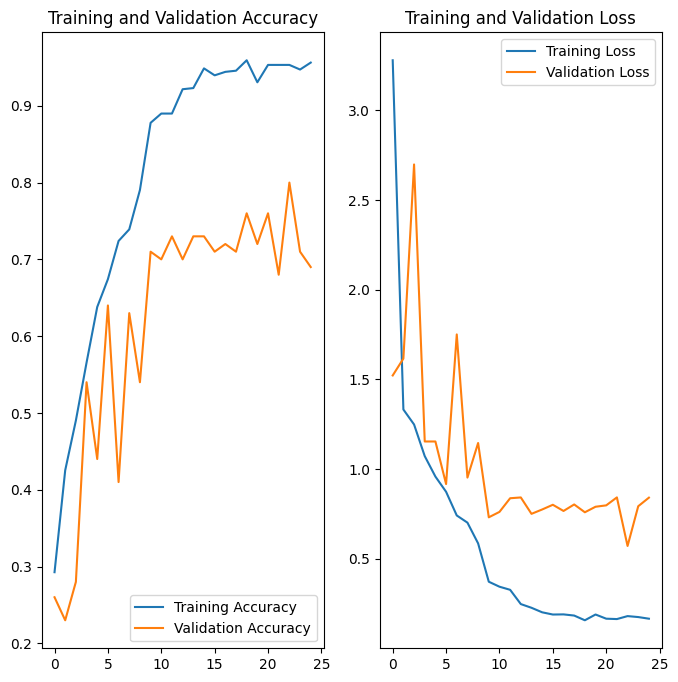

In [ ]:
plot_acc(model_5,num_epochs)

#### **Observations**


### Comparing Pool Size - Model 6

#### Pool Size 2,2,2

Constants
- img size = 120,120
- batch size = 7
- sequence length = 15
- Conv depth = 2

In [ ]:
batch_size = 7

model6 = Sequential()

model6.add(Conv3D(16, (3,3,3), input_shape = (15,120,120,3), padding='same'))
model6.add(BatchNormalization())
model6.add(Activation('relu'))
model6.add(MaxPooling3D(pool_size=(2,2,2)))


model6.add(Conv3D(32, (3,3,3),padding='same'))
model6.add(BatchNormalization())
model6.add(Activation('relu'))
model6.add(MaxPooling3D(pool_size=(2,2,2)))
model6.add(Dropout(0.3))

model6.add(Flatten())

model6.add(Dense(512, activation='relu'))
model6.add(Dropout(0.5))


model6.add(Dense(5))
model6.add(Activation('softmax'))

In [ ]:
optimiser = optimizers.SGD(learning_rate=0.01, momentum=0.5)
model6.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (model6.summary())

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_11 (Conv3D)          (None, 15, 120, 120, 16)  1312      
                                                                 
 batch_normalization_11 (Bat  (None, 15, 120, 120, 16)  64       
 chNormalization)                                                
                                                                 
 activation_16 (Activation)  (None, 15, 120, 120, 16)  0         
                                                                 
 max_pooling3d_12 (MaxPoolin  (None, 7, 60, 60, 16)    0         
 g3D)                                                            
                                                                 
 conv3d_12 (Conv3D)          (None, 7, 60, 60, 32)     13856     
                                                                 
 batch_normalization_12 (Bat  (None, 7, 60, 60, 32)   

In [ ]:
img_h=120
img_w = 120
sequence_index=[i for i in range(0,30,2)]

train_generator = generator(train_path, train_doc, batch_size, img_h, img_w, sequence_index)
val_generator = generator(val_path, val_doc, batch_size, img_h, img_w, sequence_index)

In [ ]:
model_name = 'model_6_pool222_' + str(curr_dt_time).replace('-','')

if not os.path.exists(model_name):

    os.mkdir(model_name)

filepath = model_name +"/" + model_name + '.h5'

checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True, save_weights_only=False, mode='auto')

LR = ReduceLROnPlateau(monitor = 'val_loss',
                      factor=0.3,
                      patience=3,
                      verbose=1)
callbacks_list = [checkpoint, LR]

In [ ]:
if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1

In [ ]:
model_6 = model6.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1,
                    callbacks=callbacks_list, validation_data=val_generator,
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

Source path =  /content/Project_data/train ; batch size = 7
Epoch 1/25
95/95 [==============================] - ETA: 0s - loss: 10.0967 - categorical_accuracy: 0.2398Source path =  /content/Project_data/val ; batch size = 7

Epoch 1: val_loss improved from inf to 1.73100, saving model to model_6_pool222_20230805/model_6_pool222_20230805.h5
95/95 [==============================] - 107s 1s/step - loss: 10.0967 - categorical_accuracy: 0.2398 - val_loss: 1.7310 - val_categorical_accuracy: 0.2400 - lr: 0.0100
Epoch 2/25
95/95 [==============================] - ETA: 0s - loss: 1.5108 - categorical_accuracy: 0.3665
Epoch 2: val_loss improved from 1.73100 to 1.43907, saving model to model_6_pool222_20230805/model_6_pool222_20230805.h5
95/95 [==============================] - 107s 1s/step - loss: 1.5108 - categorical_accuracy: 0.3665 - val_loss: 1.4391 - val_categorical_accuracy: 0.3600 - lr: 0.0100
Epoch 3/25
95/95 [==============================] - ETA: 0s - loss: 1.3864 - categorical_accurac

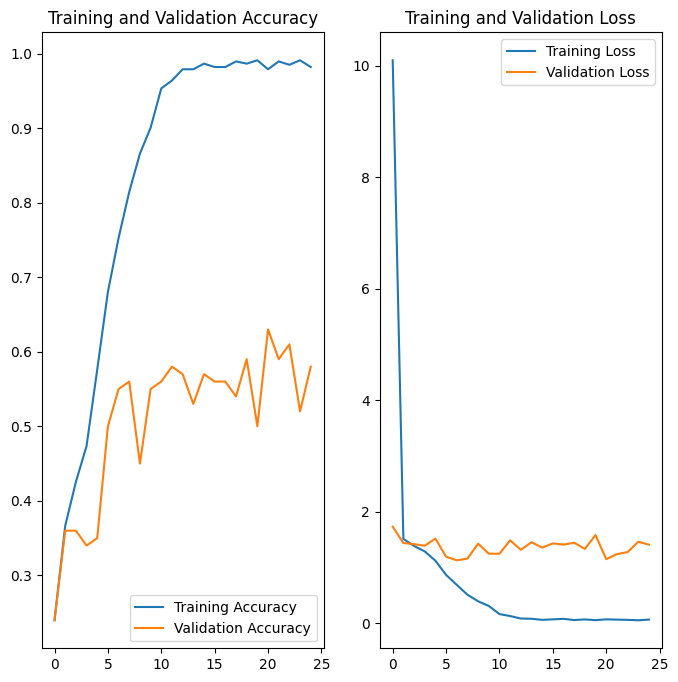

In [ ]:
plot_acc(model_6,num_epochs)

#### **Observations**


### Using LeakyReLU activation - Model 7

#### Leaky ReLU aplha of 0.01

Constants
- img size = 120,120
- batch size = 7
- sequence length = 15
- Conv depth = 2
- Max Pooling = 3,3,3

In [ ]:
from keras.layers import LeakyReLU


LeakyReLU = LeakyReLU(alpha=0.01)

batch_size = 7

model7 = Sequential()

model7.add(Conv3D(16, (3,3,3), input_shape = (15,120,120,3), padding='same'))
model7.add(BatchNormalization())
model7.add(Activation(LeakyReLU))
model7.add(MaxPooling3D(pool_size=(3,3,3)))


model7.add(Conv3D(32, (3,3,3),padding='same'))
model7.add(BatchNormalization())
model7.add(Activation(LeakyReLU))
model7.add(MaxPooling3D(pool_size=(3,3,3)))
model7.add(Dropout(0.3))

model7.add(Flatten())

model7.add(Dense(512, activation=LeakyReLU))
model7.add(Dropout(0.5))


model7.add(Dense(5))
model7.add(Activation('softmax'))

In [ ]:
optimiser = optimizers.SGD(learning_rate=0.01, momentum=0.5)
model7.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (model7.summary())

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_13 (Conv3D)          (None, 15, 120, 120, 16)  1312      
                                                                 
 batch_normalization_13 (Bat  (None, 15, 120, 120, 16)  64       
 chNormalization)                                                
                                                                 
 activation_19 (Activation)  (None, 15, 120, 120, 16)  0         
                                                                 
 max_pooling3d_14 (MaxPoolin  (None, 5, 40, 40, 16)    0         
 g3D)                                                            
                                                                 
 conv3d_14 (Conv3D)          (None, 5, 40, 40, 32)     13856     
                                                                 
 batch_normalization_14 (Bat  (None, 5, 40, 40, 32)   

In [ ]:
img_h=120
img_w = 120
sequence_index=[i for i in range(0,30,2)]

train_generator = generator(train_path, train_doc, batch_size, img_h, img_w, sequence_index)
val_generator = generator(val_path, val_doc, batch_size, img_h, img_w, sequence_index)

In [ ]:
model_name = 'model_7_leakyrelu_' + str(curr_dt_time).replace('-','')

if not os.path.exists(model_name):

    os.mkdir(model_name)

filepath = model_name +"/" + model_name + '.h5'

checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True, save_weights_only=False, mode='auto')

LR = ReduceLROnPlateau(monitor = 'val_loss',
                      factor=0.3,
                      patience=3,
                      verbose=1)
callbacks_list = [checkpoint, LR]

In [ ]:
model_7 = model7.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1,
                    callbacks=callbacks_list, validation_data=val_generator,
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

Source path =  /content/Project_data/train ; batch size = 7
Epoch 1/25
95/95 [==============================] - ETA: 0s - loss: 2.5184 - categorical_accuracy: 0.3198Source path =  /content/Project_data/val ; batch size = 7

Epoch 1: val_loss improved from inf to 1.44709, saving model to model_7_leakyrelu_20230805/model_7_leakyrelu_20230805.h5
95/95 [==============================] - 102s 1s/step - loss: 2.5184 - categorical_accuracy: 0.3198 - val_loss: 1.4471 - val_categorical_accuracy: 0.4400 - lr: 0.0100
Epoch 2/25
95/95 [==============================] - ETA: 0s - loss: 1.3385 - categorical_accuracy: 0.4495
Epoch 2: val_loss improved from 1.44709 to 1.26899, saving model to model_7_leakyrelu_20230805/model_7_leakyrelu_20230805.h5
95/95 [==============================] - 103s 1s/step - loss: 1.3385 - categorical_accuracy: 0.4495 - val_loss: 1.2690 - val_categorical_accuracy: 0.5100 - lr: 0.0100
Epoch 3/25
95/95 [==============================] - ETA: 0s - loss: 1.1422 - categorical_a

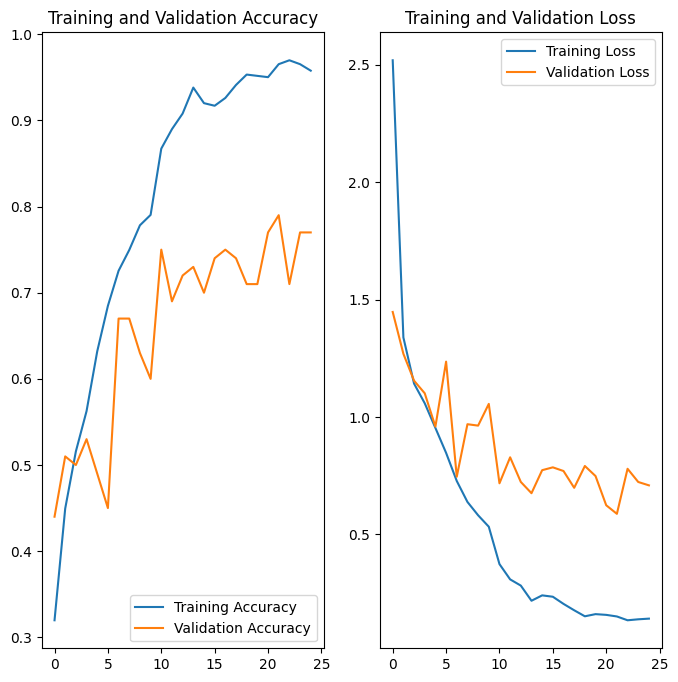

In [ ]:
plot_acc(model_7,num_epochs)

#### **Observations**

## ConvRNN Architectures



#### ConvRNN Model 1 - LSTM


Constants

- LSTM Cells = 32
- img size = 120,120
- batch size = 7
- sequence length = 15
- Conv depth = 2
- Max Pooling = 3,3


In [ ]:
batch_size = 7

model8 = Sequential()

model8.add(Input(shape=(15,120,120,3)))

model8.add(TimeDistributed(Conv2D(16, (3,3), padding='same', activation='relu')))
model8.add(TimeDistributed(BatchNormalization()))
model8.add(TimeDistributed(MaxPooling2D((3,3))))

model8.add(TimeDistributed(Conv2D(32, (3,3), padding='same', activation='relu')))
model8.add(TimeDistributed(BatchNormalization()))
model8.add(TimeDistributed(MaxPooling2D((3,3))))
model8.add(Dropout(0.3))

model8.add(TimeDistributed(Flatten()))

model8.add(LSTM(32))
model8.add(Dropout(0.3))



model8.add(Dense(5, activation='softmax'))


In [ ]:
optimiser = optimizers.SGD(learning_rate = 0.01, momentum=0.5)
model8.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print(model8.summary())

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed (TimeDistr  (None, 15, 120, 120, 16)  448      
 ibuted)                                                         
                                                                 
 time_distributed_1 (TimeDis  (None, 15, 120, 120, 16)  64       
 tributed)                                                       
                                                                 
 time_distributed_2 (TimeDis  (None, 15, 40, 40, 16)   0         
 tributed)                                                       
                                                                 
 time_distributed_3 (TimeDis  (None, 15, 40, 40, 32)   4640      
 tributed)                                                       
                                                                 
 time_distributed_4 (TimeDis  (None, 15, 40, 40, 32)  

In [ ]:
img_h=120
img_w = 120
sequence_index=[i for i in range(0,30,2)]

train_generator = generator(train_path, train_doc, batch_size, img_h, img_w, sequence_index)
val_generator = generator(val_path, val_doc, batch_size, img_h, img_w, sequence_index)

In [ ]:
model_name = 'lstm_base_32_cells_' + str(curr_dt_time).replace('-','')

if not os.path.exists(model_name):

    os.mkdir(model_name)

filepath = model_name +"/" + model_name + '.h5'

checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True, save_weights_only=False, mode='auto')

LR = ReduceLROnPlateau(monitor = 'val_loss',
                      factor=0.3,
                      patience=3,
                      verbose=1)
callbacks_list = [checkpoint, LR]

In [ ]:
if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1

In [ ]:
model_8 = model8.fit(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1,
                    callbacks=callbacks_list, validation_data=val_generator,
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)


Source path =  /content/Project_data/train ; batch size = 7
Epoch 1/25
95/95 [==============================] - ETA: 0s - loss: 1.5222 - categorical_accuracy: 0.3394Source path =  /content/Project_data/val ; batch size = 7

Epoch 1: val_loss improved from inf to 1.55314, saving model to lstm_base_32_cells_20230805/lstm_base_32_cells_20230805.h5
95/95 [==============================] - 107s 1s/step - loss: 1.5222 - categorical_accuracy: 0.3394 - val_loss: 1.5531 - val_categorical_accuracy: 0.2600 - lr: 0.0100
Epoch 2/25
95/95 [==============================] - ETA: 0s - loss: 1.3128 - categorical_accuracy: 0.4827
Epoch 2: val_loss did not improve from 1.55314
95/95 [==============================] - 101s 1s/step - loss: 1.3128 - categorical_accuracy: 0.4827 - val_loss: 1.7313 - val_categorical_accuracy: 0.1800 - lr: 0.0100
Epoch 3/25
95/95 [==============================] - ETA: 0s - loss: 1.1921 - categorical_accuracy: 0.5324
Epoch 3: val_loss improved from 1.55314 to 1.47227, saving m

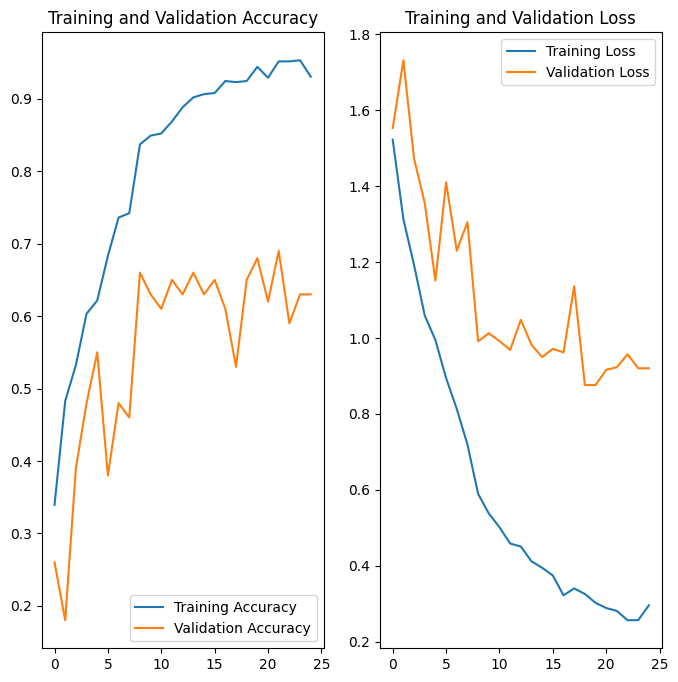

In [ ]:
plot_acc(model_8,num_epochs)

#### **Observations**

rapid overfitting but also rapid increase in validation accuracy at first but then plateau.

### ConvRNN Model 2 - GRU

#### GRU Cells

Constants
- GRU Cells = 32
- img size = 120,120
- batch size = 7
- sequence length = 15
- Conv depth = 2
- Max Pooling = 3,3




In [ ]:
batch_size = 7

model9 = Sequential()

model9.add(Input(shape=(15,120,120,3)))

model9.add(TimeDistributed(Conv2D(16, (3,3), padding='same', activation='relu')))
model9.add(TimeDistributed(BatchNormalization()))
model9.add(TimeDistributed(MaxPooling2D((3,3))))

model9.add(TimeDistributed(Conv2D(32, (3,3), padding='same', activation='relu')))
model9.add(TimeDistributed(BatchNormalization()))
model9.add(TimeDistributed(MaxPooling2D((3,3))))
model9.add(Dropout(0.3))

model9.add(TimeDistributed(Flatten()))

model9.add(GRU(32))
model9.add(Dropout(0.3))



model9.add(Dense(5, activation='softmax'))

In [ ]:
optimiser = optimizers.SGD(learning_rate = 0.01, momentum=0.5)
model9.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print(model9.summary())

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed_7 (TimeDis  (None, 15, 120, 120, 16)  448      
 tributed)                                                       
                                                                 
 time_distributed_8 (TimeDis  (None, 15, 120, 120, 16)  64       
 tributed)                                                       
                                                                 
 time_distributed_9 (TimeDis  (None, 15, 40, 40, 16)   0         
 tributed)                                                       
                                                                 
 time_distributed_10 (TimeDi  (None, 15, 40, 40, 32)   4640      
 stributed)                                                      
                                                                 
 time_distributed_11 (TimeDi  (None, 15, 40, 40, 32)  

In [ ]:
img_h=120
img_w = 120
sequence_index=[i for i in range(0,30,2)]

train_generator = generator(train_path, train_doc, batch_size, img_h, img_w, sequence_index)
val_generator = generator(val_path, val_doc, batch_size, img_h, img_w, sequence_index)

In [ ]:
model_name = 'gru_base_32_cells_' + str(curr_dt_time).replace('-','')

if not os.path.exists(model_name):

    os.mkdir(model_name)

filepath = model_name +"/" + model_name + '.h5'

checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True, save_weights_only=False, mode='auto')

LR = ReduceLROnPlateau(monitor = 'val_loss',
                      factor=0.3,
                      patience=3,
                      verbose=1)
callbacks_list = [checkpoint, LR]

In [ ]:
if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1

In [ ]:
model_9 = model9.fit(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1,
                    callbacks=callbacks_list, validation_data=val_generator,
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

Source path =  /content/Project_data/train ; batch size = 7
Epoch 1/25
95/95 [==============================] - ETA: 0s - loss: 1.6389 - categorical_accuracy: 0.3137Source path =  /content/Project_data/val ; batch size = 7

Epoch 1: val_loss improved from inf to 1.50321, saving model to gru_base_32_cells_20230805/gru_base_32_cells_20230805.h5
95/95 [==============================] - 107s 1s/step - loss: 1.6389 - categorical_accuracy: 0.3137 - val_loss: 1.5032 - val_categorical_accuracy: 0.2800 - lr: 0.0100
Epoch 2/25
95/95 [==============================] - ETA: 0s - loss: 1.3898 - categorical_accuracy: 0.4027
Epoch 2: val_loss did not improve from 1.50321
95/95 [==============================] - 104s 1s/step - loss: 1.3898 - categorical_accuracy: 0.4027 - val_loss: 1.7109 - val_categorical_accuracy: 0.3900 - lr: 0.0100
Epoch 3/25
95/95 [==============================] - ETA: 0s - loss: 1.1606 - categorical_accuracy: 0.5370
Epoch 3: val_loss improved from 1.50321 to 1.33121, saving mod

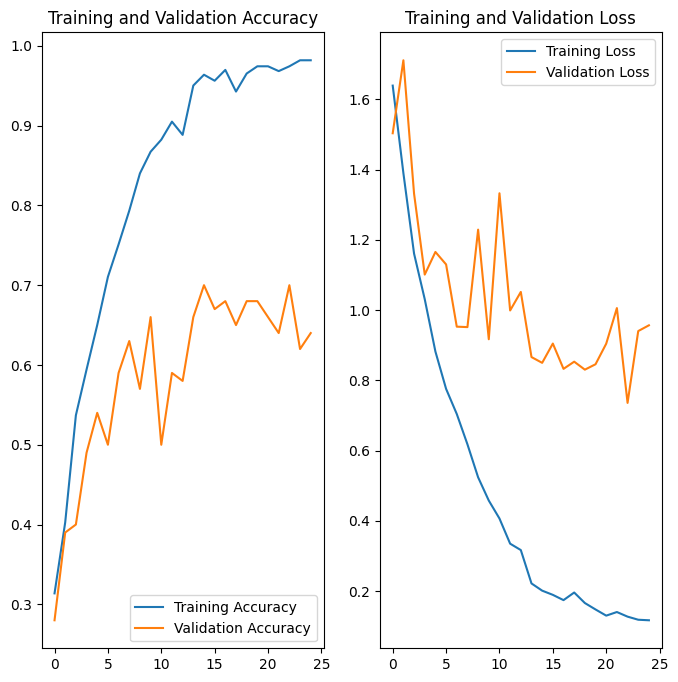

In [ ]:
plot_acc(model_9,num_epochs)

#### **Observations**


### ConvRNN Model 3 - Optimiser Variation

#### Model 10 - Adam Optimiser
Constants
- GRU Cells = 32
- img size = 120,120
- batch size = 7
- sequence length = 15
- Conv depth = 2
- Max Pooling = 3,3

In [ ]:
batch_size = 7

model10 = Sequential()

model10.add(Input(shape=(15,120,120,3)))

model10.add(TimeDistributed(Conv2D(16, (3,3), padding='same', activation='relu')))
model10.add(TimeDistributed(BatchNormalization()))
model10.add(TimeDistributed(MaxPooling2D((3,3))))

model10.add(TimeDistributed(Conv2D(32, (3,3), padding='same', activation='relu')))
model10.add(TimeDistributed(BatchNormalization()))
model10.add(TimeDistributed(MaxPooling2D((3,3))))
model10.add(Dropout(0.3))

model10.add(TimeDistributed(Flatten()))

model10.add(GRU(32))
model10.add(Dropout(0.3))



model10.add(Dense(5, activation='softmax'))

In [ ]:
optimiser = optimizers.Adam()
model10.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print(model10.summary())

Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed_14 (TimeDi  (None, 15, 120, 120, 16)  448      
 stributed)                                                      
                                                                 
 time_distributed_15 (TimeDi  (None, 15, 120, 120, 16)  64       
 stributed)                                                      
                                                                 
 time_distributed_16 (TimeDi  (None, 15, 40, 40, 16)   0         
 stributed)                                                      
                                                                 
 time_distributed_17 (TimeDi  (None, 15, 40, 40, 32)   4640      
 stributed)                                                      
                                                                 
 time_distributed_18 (TimeDi  (None, 15, 40, 40, 32)  

In [ ]:
img_h=120
img_w = 120
sequence_index=[i for i in range(0,30,2)]

train_generator = generator(train_path, train_doc, batch_size, img_h, img_w, sequence_index)
val_generator = generator(val_path, val_doc, batch_size, img_h, img_w, sequence_index)

In [ ]:
model_name = 'gru_base_Adam_' + str(curr_dt_time).replace('-','')

if not os.path.exists(model_name):

    os.mkdir(model_name)

filepath = model_name +"/" + model_name + '.h5'

checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True, save_weights_only=False, mode='auto')

LR = ReduceLROnPlateau(monitor = 'val_loss',
                      factor=0.3,
                      patience=3,
                      verbose=1)
callbacks_list = [checkpoint, LR]

In [ ]:
if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1

In [ ]:
model_10 = model10.fit(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1,
                    callbacks=callbacks_list, validation_data=val_generator,
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

Source path =  /content/Project_data/train ; batch size = 7
Epoch 1/25
95/95 [==============================] - ETA: 0s - loss: 1.6691 - categorical_accuracy: 0.2790Source path =  /content/Project_data/val ; batch size = 7

Epoch 1: val_loss improved from inf to 1.57734, saving model to gru_base_Adam_20230805/gru_base_Adam_20230805.h5
95/95 [==============================] - 108s 1s/step - loss: 1.6691 - categorical_accuracy: 0.2790 - val_loss: 1.5773 - val_categorical_accuracy: 0.3300 - lr: 0.0010
Epoch 2/25
95/95 [==============================] - ETA: 0s - loss: 1.4234 - categorical_accuracy: 0.4163
Epoch 2: val_loss did not improve from 1.57734
95/95 [==============================] - 104s 1s/step - loss: 1.4234 - categorical_accuracy: 0.4163 - val_loss: 1.7142 - val_categorical_accuracy: 0.2500 - lr: 0.0010
Epoch 3/25
95/95 [==============================] - ETA: 0s - loss: 1.3162 - categorical_accuracy: 0.4419
Epoch 3: val_loss did not improve from 1.57734
95/95 [================

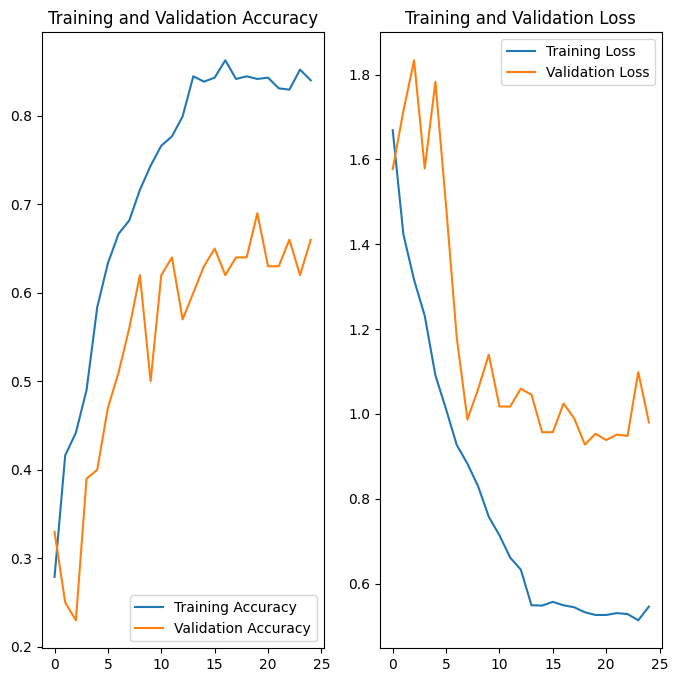

In [ ]:
plot_acc(model_10,num_epochs)

#### **Observations**

model overfit less with similar accuracy but higher loss values. perhaps longer training time is needed

### ConvRNN Model 4 - lower batch size


#### Model 11 - Batch size = 5

Constants
- GRU Cells = 32
- img size = 120,120
- sequence length = 15
- Conv depth = 2
- Max Pooling = 3,3

In [ ]:
batch_size = 5

model11 = Sequential()

model11.add(Input(shape=(15,120,120,3)))

model11.add(TimeDistributed(Conv2D(16, (3,3), padding='same', activation='relu')))
model11.add(TimeDistributed(BatchNormalization()))
model11.add(TimeDistributed(MaxPooling2D((3,3))))

model11.add(TimeDistributed(Conv2D(32, (3,3), padding='same', activation='relu')))
model11.add(TimeDistributed(BatchNormalization()))
model11.add(TimeDistributed(MaxPooling2D((3,3))))
model11.add(Dropout(0.3))

model11.add(TimeDistributed(Flatten()))

model11.add(GRU(32))
model11.add(Dropout(0.3))



model11.add(Dense(5, activation='softmax'))

In [ ]:
optimiser = optimizers.Adam()
model11.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print(model11.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed (TimeDistr  (None, 15, 120, 120, 16)  448      
 ibuted)                                                         
                                                                 
 time_distributed_1 (TimeDis  (None, 15, 120, 120, 16)  64       
 tributed)                                                       
                                                                 
 time_distributed_2 (TimeDis  (None, 15, 40, 40, 16)   0         
 tributed)                                                       
                                                                 
 time_distributed_3 (TimeDis  (None, 15, 40, 40, 32)   4640      
 tributed)                                                       
                                                                 
 time_distributed_4 (TimeDis  (None, 15, 40, 40, 32)   1

In [ ]:
img_h=120
img_w = 120
sequence_index=[i for i in range(0,30,2)]

train_generator = generator(train_path, train_doc, batch_size, img_h, img_w, sequence_index)
val_generator = generator(val_path, val_doc, batch_size, img_h, img_w, sequence_index)

In [ ]:
model_name = 'gru_base_batch5_' + str(curr_dt_time).replace('-','')

if not os.path.exists(model_name):

    os.mkdir(model_name)

filepath = model_name +"/" + model_name + '.h5'

checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True, save_weights_only=False, mode='auto')

LR = ReduceLROnPlateau(monitor = 'val_loss',
                      factor=0.3,
                      patience=3,
                      verbose=1)
callbacks_list = [checkpoint, LR]

In [ ]:
if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1

In [ ]:
model_11 = model11.fit(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1,
                    callbacks=callbacks_list, validation_data=val_generator,
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

Source path =  /content/Project_data/train ; batch size = 5
Epoch 1/25
133/133 [==============================] - ETA: 0s - loss: 1.7575 - categorical_accuracy: 0.2549Source path =  /content/Project_data/val ; batch size = 5

Epoch 1: val_loss improved from inf to 1.87898, saving model to gru_base_batch5_20230806/gru_base_batch5_20230806.h5
133/133 [==============================] - 122s 830ms/step - loss: 1.7575 - categorical_accuracy: 0.2549 - val_loss: 1.8790 - val_categorical_accuracy: 0.2400 - lr: 0.0010
Epoch 2/25
133/133 [==============================] - ETA: 0s - loss: 1.6500 - categorical_accuracy: 0.2986
Epoch 2: val_loss improved from 1.87898 to 1.74251, saving model to gru_base_batch5_20230806/gru_base_batch5_20230806.h5
133/133 [==============================] - 114s 863ms/step - loss: 1.6500 - categorical_accuracy: 0.2986 - val_loss: 1.7425 - val_categorical_accuracy: 0.2700 - lr: 0.0010
Epoch 3/25
133/133 [==============================] - ETA: 0s - loss: 1.4871 - categ

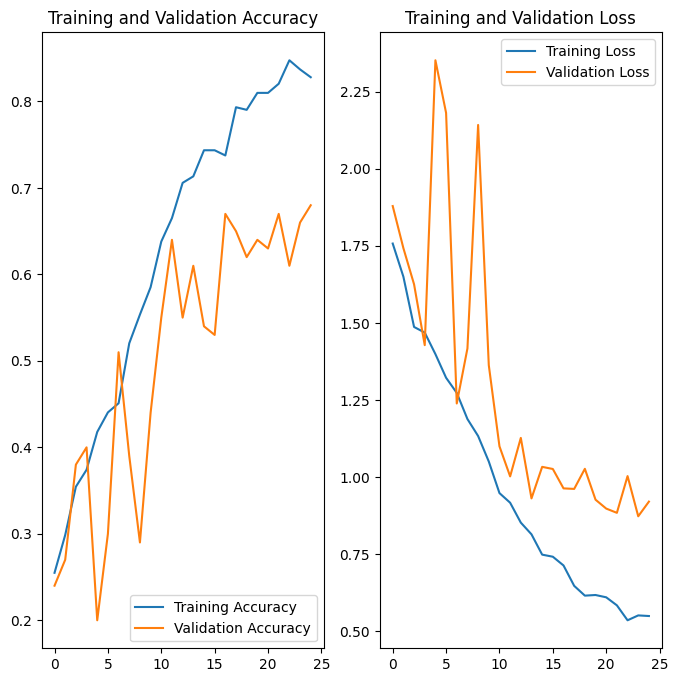

In [ ]:
plot_acc(model_11,num_epochs)

### ConvRNN Model 5 - More cells

#### Model 12 GRU cells = 64

Constants
- img size = 120,120
- batch size = 5
- sequence length = 15
- Conv depth = 2

In [ ]:
batch_size = 5

model12 = Sequential()

model12.add(Input(shape=(15,120,120,3)))

model12.add(TimeDistributed(Conv2D(16, (3,3), padding='same', activation='relu')))
model12.add(TimeDistributed(BatchNormalization()))
model12.add(TimeDistributed(MaxPooling2D((3,3))))

model12.add(TimeDistributed(Conv2D(32, (3,3), padding='same', activation='relu')))
model12.add(TimeDistributed(BatchNormalization()))
model12.add(TimeDistributed(MaxPooling2D((3,3))))
model12.add(Dropout(0.3))

model12.add(TimeDistributed(Flatten()))

model12.add(GRU(64))
model12.add(Dropout(0.3))



model12.add(Dense(5, activation='softmax'))

In [ ]:
optimiser = optimizers.Adam()
model12.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print(model12.summary())

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed_7 (TimeDis  (None, 15, 120, 120, 16)  448      
 tributed)                                                       
                                                                 
 time_distributed_8 (TimeDis  (None, 15, 120, 120, 16)  64       
 tributed)                                                       
                                                                 
 time_distributed_9 (TimeDis  (None, 15, 40, 40, 16)   0         
 tributed)                                                       
                                                                 
 time_distributed_10 (TimeDi  (None, 15, 40, 40, 32)   4640      
 stributed)                                                      
                                                                 
 time_distributed_11 (TimeDi  (None, 15, 40, 40, 32)  

In [ ]:
img_h=120
img_w = 120
sequence_index=[i for i in range(0,30,2)]

train_generator = generator(train_path, train_doc, batch_size, img_h, img_w, sequence_index)
val_generator = generator(val_path, val_doc, batch_size, img_h, img_w, sequence_index)


In [ ]:
model_name = 'gru_base_gru64_' + str(curr_dt_time).replace('-','')

if not os.path.exists(model_name):

    os.mkdir(model_name)

filepath = model_name +"/" + model_name + '.h5'

checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True, save_weights_only=False, mode='auto')

LR = ReduceLROnPlateau(monitor = 'val_loss',
                      factor=0.3,
                      patience=3,
                      verbose=1)
callbacks_list = [checkpoint, LR]

In [ ]:
if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1

In [ ]:
model_12 = model12.fit(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1,
                    callbacks=callbacks_list, validation_data=val_generator,
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

Source path =  /content/Project_data/train ; batch size = 5
Epoch 1/25
133/133 [==============================] - ETA: 0s - loss: 1.6542 - categorical_accuracy: 0.2971Source path =  /content/Project_data/val ; batch size = 5

Epoch 1: val_loss improved from inf to 1.71667, saving model to gru_base_gru64_20230806/gru_base_gru64_20230806.h5
133/133 [==============================] - 111s 825ms/step - loss: 1.6542 - categorical_accuracy: 0.2971 - val_loss: 1.7167 - val_categorical_accuracy: 0.3800 - lr: 0.0010
Epoch 2/25
133/133 [==============================] - ETA: 0s - loss: 1.5519 - categorical_accuracy: 0.3363
Epoch 2: val_loss did not improve from 1.71667
133/133 [==============================] - 107s 812ms/step - loss: 1.5519 - categorical_accuracy: 0.3363 - val_loss: 2.0433 - val_categorical_accuracy: 0.2500 - lr: 0.0010
Epoch 3/25
133/133 [==============================] - ETA: 0s - loss: 1.4062 - categorical_accuracy: 0.3846
Epoch 3: val_loss improved from 1.71667 to 1.55700, 

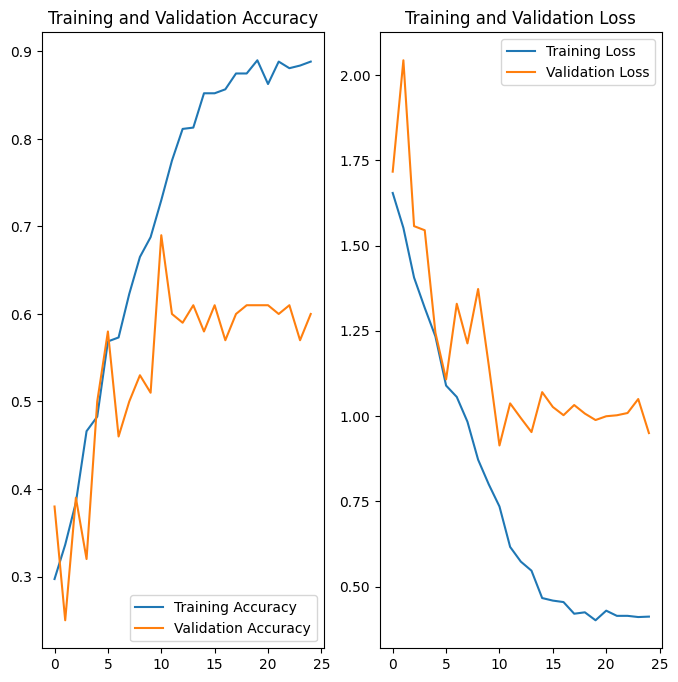

In [ ]:
plot_acc(model_12,num_epochs)

#### **Observations**

More GRU cells leads to more overfitting and no improvement vs fewer in terms of validation metrics

### ConvRNN Model 6 - pool size

#### Model 13 - pool size = 2,2, stride 2

Constants
- img size = 120,120
- batch size = 5
- sequence length = 15
- Conv depth = 2
- GRU cells = 32

In [ ]:
batch_size = 5

model13 = Sequential()

model13.add(Input(shape=(15,120,120,3)))

model13.add(TimeDistributed(Conv2D(16, (3,3), padding='same', activation='relu')))
model13.add(TimeDistributed(BatchNormalization()))
model13.add(TimeDistributed(MaxPooling2D(pool_size=(2,2), strides=2)))

model13.add(TimeDistributed(Conv2D(32, (3,3), padding='same', activation='relu')))
model13.add(TimeDistributed(BatchNormalization()))
model13.add(TimeDistributed(MaxPooling2D(pool_size=(2,2),strides=2)))
model13.add(Dropout(0.3))

model13.add(TimeDistributed(Flatten()))

model13.add(GRU(32))
model13.add(Dropout(0.3))



model13.add(Dense(5, activation='softmax'))

In [ ]:
optimiser = optimizers.Adam()
model13.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print(model13.summary())

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed_14 (TimeDi  (None, 15, 120, 120, 16)  448      
 stributed)                                                      
                                                                 
 time_distributed_15 (TimeDi  (None, 15, 120, 120, 16)  64       
 stributed)                                                      
                                                                 
 time_distributed_16 (TimeDi  (None, 15, 60, 60, 16)   0         
 stributed)                                                      
                                                                 
 time_distributed_17 (TimeDi  (None, 15, 60, 60, 32)   4640      
 stributed)                                                      
                                                                 
 time_distributed_18 (TimeDi  (None, 15, 60, 60, 32)  

In [ ]:
img_h=120
img_w = 120
sequence_index=[i for i in range(0,30,2)]

train_generator = generator(train_path, train_doc, batch_size, img_h, img_w, sequence_index)
val_generator = generator(val_path, val_doc, batch_size, img_h, img_w, sequence_index)


In [ ]:
model_name = 'gru_base_pool22_s2_' + str(curr_dt_time).replace('-','')

if not os.path.exists(model_name):

    os.mkdir(model_name)

filepath = model_name +"/" + model_name + '.h5'

checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True, save_weights_only=False, mode='auto')

LR = ReduceLROnPlateau(monitor = 'val_loss',
                      factor=0.3,
                      patience=3,
                      verbose=1)
callbacks_list = [checkpoint, LR]

In [ ]:
if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1

In [ ]:
model_13 = model13.fit(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1,
                    callbacks=callbacks_list, validation_data=val_generator,
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

Source path =  /content/Project_data/train ; batch size = 5
Epoch 1/25
133/133 [==============================] - ETA: 0s - loss: 1.8596 - categorical_accuracy: 0.2036Source path =  /content/Project_data/val ; batch size = 5

Epoch 1: val_loss improved from inf to 1.76916, saving model to gru_base_pool22_s2_20230806/gru_base_pool22_s2_20230806.h5
133/133 [==============================] - 107s 795ms/step - loss: 1.8596 - categorical_accuracy: 0.2036 - val_loss: 1.7692 - val_categorical_accuracy: 0.2700 - lr: 0.0010
Epoch 2/25
133/133 [==============================] - ETA: 0s - loss: 1.6557 - categorical_accuracy: 0.2836
Epoch 2: val_loss improved from 1.76916 to 1.63615, saving model to gru_base_pool22_s2_20230806/gru_base_pool22_s2_20230806.h5
133/133 [==============================] - 105s 797ms/step - loss: 1.6557 - categorical_accuracy: 0.2836 - val_loss: 1.6362 - val_categorical_accuracy: 0.3400 - lr: 0.0010
Epoch 3/25
133/133 [==============================] - ETA: 0s - loss: 1.

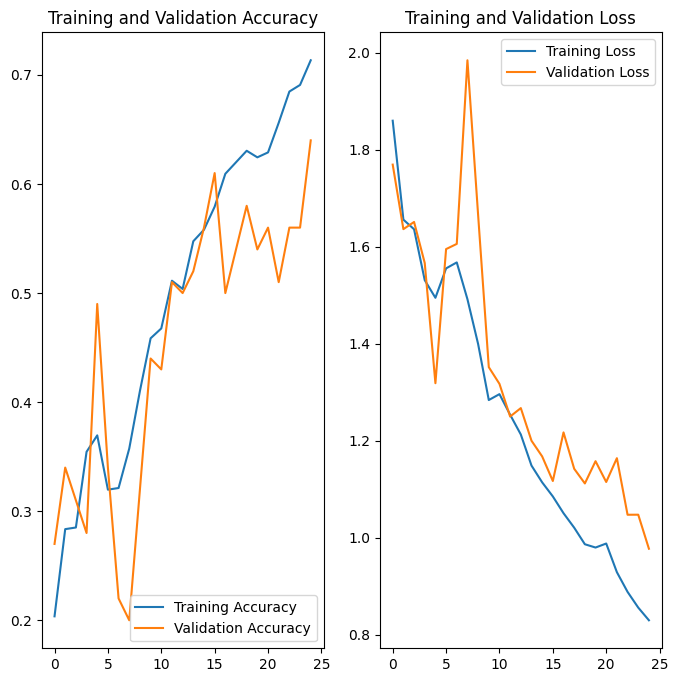

In [ ]:
plot_acc(model_13,num_epochs)

#### **Observations**

seems like the most stable model so far. will increase depth and run again

### ConvRNN Model 7 - More Conv



#### Model 14 - Another Conv Layer

Constants
- img size = 120,120
- batch size = 5
- sequence length = 15
- GRU cells = 32
- pool size = (2,2) s=2



In [ ]:
batch_size = 5

model14 = Sequential()

model14.add(Input(shape=(15,120,120,3)))

model14.add(TimeDistributed(Conv2D(16, (3,3), padding='same', activation='relu')))
model14.add(TimeDistributed(BatchNormalization()))
model14.add(TimeDistributed(MaxPooling2D(pool_size=(2,2), strides=2)))

model14.add(TimeDistributed(Conv2D(32, (3,3), padding='same', activation='relu')))
model14.add(TimeDistributed(BatchNormalization()))
model14.add(TimeDistributed(MaxPooling2D(pool_size=(2,2),strides=2)))
model14.add(Dropout(0.3))

model14.add(TimeDistributed(Conv2D(64, (3,3), padding='same', activation='relu')))
model14.add(TimeDistributed(BatchNormalization()))
model14.add(TimeDistributed(MaxPooling2D(pool_size=(2,2),strides=2)))

model14.add(TimeDistributed(Flatten()))

model14.add(GRU(32))
model14.add(Dropout(0.3))



model14.add(Dense(5, activation='softmax'))

In [ ]:
optimiser = optimizers.Adam()
model14.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print(model14.summary())

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed_52 (TimeDi  (None, 15, 120, 120, 16)  448      
 stributed)                                                      
                                                                 
 time_distributed_53 (TimeDi  (None, 15, 120, 120, 16)  64       
 stributed)                                                      
                                                                 
 time_distributed_54 (TimeDi  (None, 15, 60, 60, 16)   0         
 stributed)                                                      
                                                                 
 time_distributed_55 (TimeDi  (None, 15, 60, 60, 32)   4640      
 stributed)                                                      
                                                                 
 time_distributed_56 (TimeDi  (None, 15, 60, 60, 32)  

In [ ]:
img_h=120
img_w = 120
sequence_index=[i for i in range(0,30,2)]

train_generator = generator(train_path, train_doc, batch_size, img_h, img_w, sequence_index)
val_generator = generator(val_path, val_doc, batch_size, img_h, img_w, sequence_index)

In [ ]:
model_name = 'gru_base_deep_' + str(curr_dt_time).replace('-','')

if not os.path.exists(model_name):

    os.mkdir(model_name)

filepath = model_name +"/" + model_name + '.h5'

checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True, save_weights_only=False, mode='auto')

LR = ReduceLROnPlateau(monitor = 'val_loss',
                      factor=0.3,
                      patience=3,
                      verbose=1)
callbacks_list = [checkpoint, LR]

In [ ]:
if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1

In [ ]:
model_14 = model14.fit(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1,
                    callbacks=callbacks_list, validation_data=val_generator,
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

Source path =  /content/Project_data/train ; batch size = 5
Epoch 1/40
133/133 [==============================] - ETA: 0s - loss: 2.0664 - categorical_accuracy: 0.2172Source path =  /content/Project_data/val ; batch size = 5

Epoch 1: val_loss improved from inf to 2.43156, saving model to gru_base_deep_20230806/gru_base_deep_20230806.h5
133/133 [==============================] - 105s 778ms/step - loss: 2.0664 - categorical_accuracy: 0.2172 - val_loss: 2.4316 - val_categorical_accuracy: 0.2200 - lr: 0.0010
Epoch 2/40
133/133 [==============================] - ETA: 0s - loss: 1.7568 - categorical_accuracy: 0.2338
Epoch 2: val_loss improved from 2.43156 to 2.37993, saving model to gru_base_deep_20230806/gru_base_deep_20230806.h5
133/133 [==============================] - 101s 767ms/step - loss: 1.7568 - categorical_accuracy: 0.2338 - val_loss: 2.3799 - val_categorical_accuracy: 0.1400 - lr: 0.0010
Epoch 3/40
133/133 [==============================] - ETA: 0s - loss: 1.7996 - categorical_a

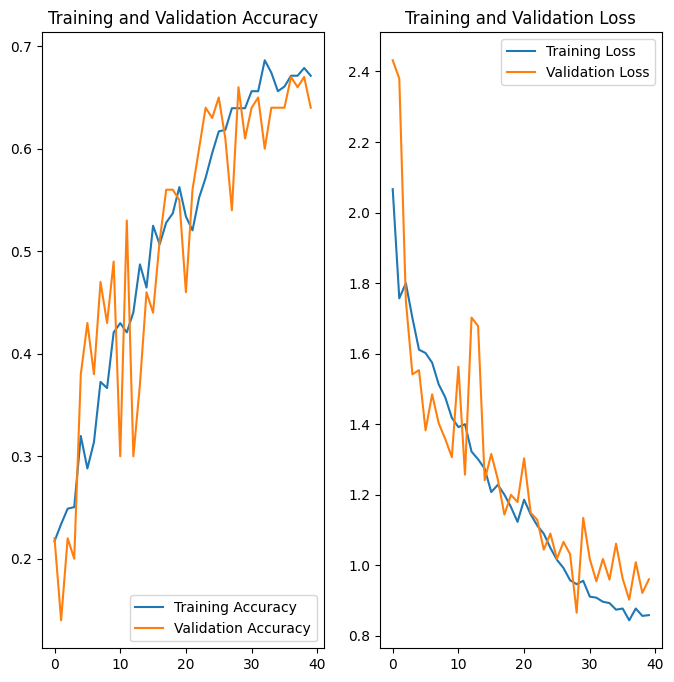

In [ ]:
plot_acc(model_14,num_epochs)

#### **Observations**
Similar stable performance to the previous model but this time accuracy and loss increased continuously.

### ConvRNN Model 8 - Skips and more


#### Model 15 -
- rnn(32) -> rnn(64)
-num_epochs(25) -> 40
-model15.add(TimeDistributed(Dense(256, activation='relu'))) #added this layer
model15.add(TimeDistributed(BatchNormalization())) ##added

Constants
- img size = 120,120
- batch size = 5
- sequence length = 15
- GRU cells = 32
- pool size = (2,2) s=2
- conv layer = 3



In [ ]:
## residual
from keras.layers import Add


batch_size = 5
num_epochs=40 ## updated from 25

input = Input(shape=(15,120,120,3))

layer1 = TimeDistributed(Conv2D(16, (3,3), padding='same', activation='relu'))(input) #main
skip1 = TimeDistributed(Conv2D(16, (1, 1), padding='same', activation='relu'))(input) #skip
layer1 = TimeDistributed(BatchNormalization())(layer1)
skip = Add()([skip1,layer1])
layer1 = TimeDistributed(MaxPooling2D(pool_size=(2,2), strides=2))(layer1)

layer2 = TimeDistributed(Conv2D(32, (3,3), padding='same', activation='relu'))(layer1)
layer2 = TimeDistributed(BatchNormalization())(layer2)
layer2 = TimeDistributed(MaxPooling2D(pool_size=(2,2),strides=2))(layer2)
layer2 = Dropout(0.3)(layer2)

layer3 = TimeDistributed(Conv2D(64, (3,3), padding='same', activation='relu'))(layer2)
skip2 = TimeDistributed(Conv2D(64, (1, 1), padding='same', activation='relu'))(layer2) #skip
layer3 = TimeDistributed(BatchNormalization())(layer3)
layer3 = Add()([skip2,layer3])
layer3 = TimeDistributed(MaxPooling2D(pool_size=(2,2),strides=2))(layer3)

layer4 = TimeDistributed(Conv2D(128, (3,3), padding='same', activation='relu'))(layer3)
layer4 = TimeDistributed(BatchNormalization())(layer4)
layer4 = TimeDistributed(MaxPooling2D(pool_size=(2,2),strides=2))(layer4)
layer4 = Dropout(0.3)(layer4)

layer5 = TimeDistributed(Conv2D(256, (3,3), padding='same', activation='relu'))(layer4)
layer5 = TimeDistributed(BatchNormalization())(layer5)
layer5 = TimeDistributed(MaxPooling2D(pool_size=(2,2),strides=2))(layer5)
layer5 = Dropout(0.3)(layer5)

flatten = TimeDistributed(Flatten())(layer5)

gru = GRU(64,)(flatten)
gru = Dropout(0.5)(gru)

output = Dense(5, activation='softmax')(gru)

model15=Model(inputs=input, outputs=output)

In [ ]:
optimiser = optimizers.Adam()
model15.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print(model15.summary())

Model: "model_4"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_13 (InputLayer)          [(None, 15, 120, 12  0           []                               
                                0, 3)]                                                            
                                                                                                  
 time_distributed_62 (TimeDistr  (None, 15, 120, 120  448        ['input_13[0][0]']               
 ibuted)                        , 16)                                                             
                                                                                                  
 time_distributed_64 (TimeDistr  (None, 15, 120, 120  64         ['time_distributed_62[0][0]']    
 ibuted)                        , 16)                                                       

In [ ]:
img_h=120
img_w = 120
sequence_index=[i for i in range(0,30,2)]

train_generator = generator(train_path, train_doc, batch_size, img_h, img_w, sequence_index)
val_generator = generator(val_path, val_doc, batch_size, img_h, img_w, sequence_index)

In [ ]:
model_name = 'gru_base_skips&more_' + str(curr_dt_time).replace('-','')

if not os.path.exists(model_name):

    os.mkdir(model_name)

filepath = model_name +"/" + model_name + '.h5'

checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True, save_weights_only=False, mode='auto')

LR = ReduceLROnPlateau(monitor = 'val_loss',
                      factor=0.2,
                      patience=3,
                      verbose=1)
callbacks_list = [checkpoint, LR]

In [ ]:
if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1

In [ ]:
model_15 = model15.fit(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1,
                    callbacks=callbacks_list, validation_data=val_generator,
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

Source path =  /content/Project_data/train ; batch size = 5
Epoch 1/40
133/133 [==============================] - ETA: 0s - loss: 1.8786 - categorical_accuracy: 0.2549Source path =  /content/Project_data/val ; batch size = 5

Epoch 1: val_loss improved from inf to 2.24439, saving model to gru_base_skips&more_20230806/gru_base_skips&more_20230806.h5
133/133 [==============================] - 105s 772ms/step - loss: 1.8786 - categorical_accuracy: 0.2549 - val_loss: 2.2444 - val_categorical_accuracy: 0.1900 - lr: 0.0010
Epoch 2/40
133/133 [==============================] - ETA: 0s - loss: 1.6291 - categorical_accuracy: 0.3213
Epoch 2: val_loss did not improve from 2.24439
133/133 [==============================] - 102s 771ms/step - loss: 1.6291 - categorical_accuracy: 0.3213 - val_loss: 2.4061 - val_categorical_accuracy: 0.1900 - lr: 0.0010
Epoch 3/40
133/133 [==============================] - ETA: 0s - loss: 1.5053 - categorical_accuracy: 0.3605
Epoch 3: val_loss improved from 2.24439 to

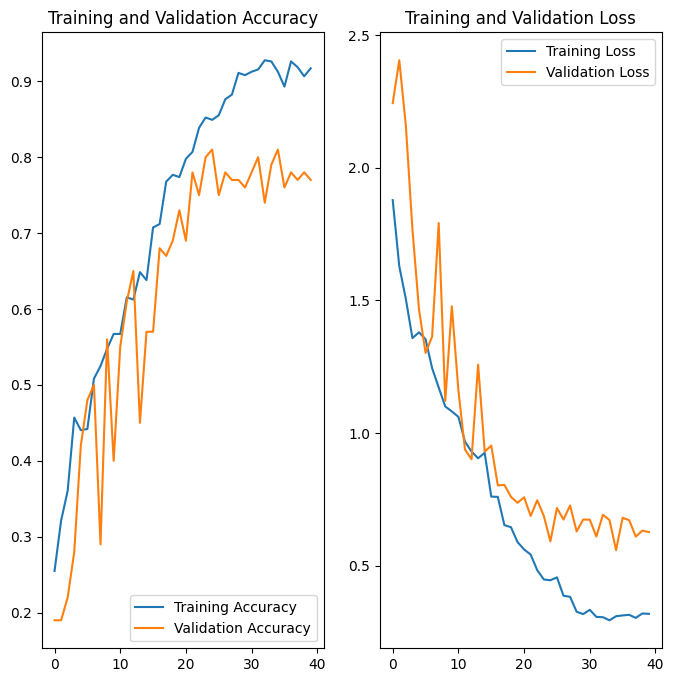

In [ ]:
plot_acc(model_15,num_epochs)

#### **Observations**


By far the best performance thus far.
After looking into how to add skip connections to models, I saw that keras.layers.Sequential was actually quite limiting so I opted for the above method of model building which allows for greater flexibility.

There is very little overfitting with training acccuracies in the mid 80s and validation in the low 80s. The changes made from previous models were
- adding two more conv layers in order to learn more features as a deeper network should learn more than a shallow one.
- implementing skip connections which can help in the back prop of errors.
- more GRU cells to attempt to learn more temporal information.

## TRANSFER LEARNING MODELS

#### Model 16 - Transfer learning ResNet50 - trainable false

Constants
- GRU cells
-

In [ ]:
from keras.applications import ResNet50V2, EfficientNetV2B3

In [ ]:
resnet = ResNet50V2(weights='imagenet', include_top=False, pooling='max')

resnet.trainable = False

94668760/94668760 [==============================] - 3s 0us/step


In [ ]:


batch_size = 5
num_epochs=40 ## updated from 25

input = Input(shape=(15,120,120,3))

layer = TimeDistributed(resnet, input_shape=(15,120,120,3))(input)

gru = GRU(64)(layer)
dropout = Dropout(0.5)(gru)
output = Dense(5, activation='softmax')(dropout)

model16 = Model(inputs=input, outputs=output)

In [ ]:
optimiser = optimizers.Adam()
model16.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print(model16.summary())

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_7 (InputLayer)        [(None, 15, 120, 120, 3)  0         
                             ]                                   
                                                                 
 time_distributed_49 (TimeDi  (None, 15, 2048)         23564800  
 stributed)                                                      
                                                                 
 gru_5 (GRU)                 (None, 64)                405888    
                                                                 
 dropout_12 (Dropout)        (None, 64)                0         
                                                                 
 dense_5 (Dense)             (None, 5)                 325       
                                                                 
Total params: 23,971,013
Trainable params: 406,213
Non-trai

In [ ]:
img_h=120
img_w = 120
sequence_index=[i for i in range(0,30,2)]

train_generator = generator(train_path, train_doc, batch_size, img_h, img_w, sequence_index)
val_generator = generator(val_path, val_doc, batch_size, img_h, img_w, sequence_index)

In [ ]:
model_name = 'resnet50v2_untrainable_' + str(curr_dt_time).replace('-','')

if not os.path.exists(model_name):

    os.mkdir(model_name)

filepath = model_name +"/" + model_name + '.h5'

checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True, save_weights_only=False, mode='auto')

LR = ReduceLROnPlateau(monitor = 'val_loss',
                      factor=0.2,
                      patience=3,
                      verbose=1)
callbacks_list = [checkpoint, LR]

In [ ]:
if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1

In [ ]:
model_16 = model16.fit(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1,
                    callbacks=callbacks_list, validation_data=val_generator,
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

Source path =  /content/Project_data/train ; batch size = 5
Epoch 1/40
133/133 [==============================] - ETA: 0s - loss: 1.9951 - categorical_accuracy: 0.2006Source path =  /content/Project_data/val ; batch size = 5

Epoch 1: val_loss improved from inf to 1.48889, saving model to resnet50v2_untrainable_20230806/resnet50v2_untrainable_20230806.h5
133/133 [==============================] - 137s 986ms/step - loss: 1.9951 - categorical_accuracy: 0.2006 - val_loss: 1.4889 - val_categorical_accuracy: 0.3300 - lr: 0.0010
Epoch 2/40
133/133 [==============================] - ETA: 0s - loss: 1.8061 - categorical_accuracy: 0.2443
Epoch 2: val_loss did not improve from 1.48889
133/133 [==============================] - 129s 978ms/step - loss: 1.8061 - categorical_accuracy: 0.2443 - val_loss: 1.5420 - val_categorical_accuracy: 0.3000 - lr: 0.0010
Epoch 3/40
133/133 [==============================] - ETA: 0s - loss: 1.7431 - categorical_accuracy: 0.2579
Epoch 3: val_loss improved from 1.48

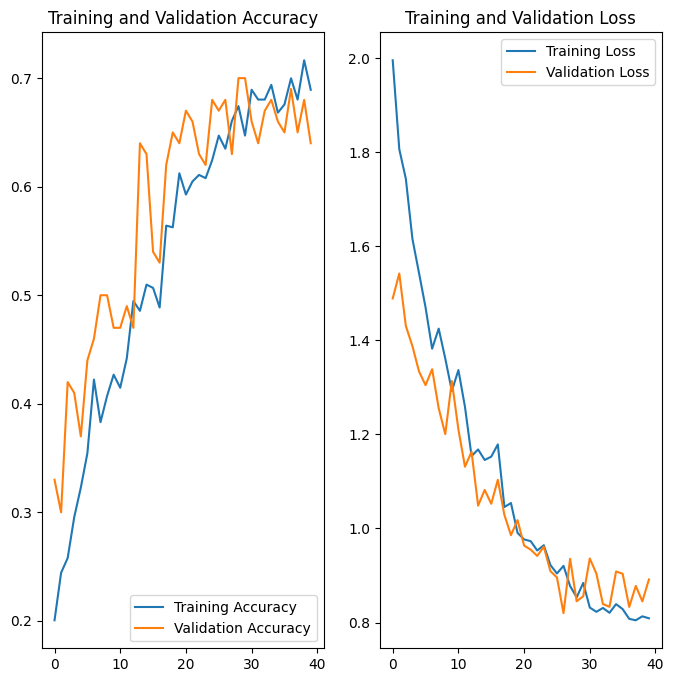

In [ ]:
plot_acc(model_16,num_epochs)

#### **Observations**

without training the weights the model reache about 65% accuracy then stalls. no overfitting.


#### Model 17 - Transfer learning ResNet50 - trainable true

Constants
- GRU cells
-

In [ ]:
resnet = ResNet50V2(weights='imagenet', include_top=False, pooling='max')

resnet.trainable = True

In [ ]:
batch_size = 5
num_epochs=40 ## updated from 25

input = Input(shape=(15,120,120,3))

layer = TimeDistributed(resnet, input_shape=(15,120,120,3))(input)

gru = GRU(64)(layer)
dropout = Dropout(0.5)(gru)
output = Dense(5, activation='softmax')(dropout)

model17 = Model(inputs=input, outputs=output)

In [ ]:
optimiser = optimizers.Adam()
model17.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print(model17.summary())

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_9 (InputLayer)        [(None, 15, 120, 120, 3)  0         
                             ]                                   
                                                                 
 time_distributed_50 (TimeDi  (None, 15, 2048)         23564800  
 stributed)                                                      
                                                                 
 gru_6 (GRU)                 (None, 64)                405888    
                                                                 
 dropout_13 (Dropout)        (None, 64)                0         
                                                                 
 dense_6 (Dense)             (None, 5)                 325       
                                                                 
Total params: 23,971,013
Trainable params: 23,925,573
Non-t

In [ ]:
img_h=120
img_w = 120
sequence_index=[i for i in range(0,30,2)]

train_generator = generator(train_path, train_doc, batch_size, img_h, img_w, sequence_index)
val_generator = generator(val_path, val_doc, batch_size, img_h, img_w, sequence_index)

In [ ]:
model_name = 'resnet50v2_trainable_' + str(curr_dt_time).replace('-','')

if not os.path.exists(model_name):

    os.mkdir(model_name)

filepath = model_name +"/" + model_name + '.h5'

checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True, save_weights_only=False, mode='auto')

LR = ReduceLROnPlateau(monitor = 'val_loss',
                      factor=0.3,
                      patience=3,
                      verbose=1)
callbacks_list = [checkpoint, LR]

In [ ]:
if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1

In [ ]:
model_17 = model17.fit(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1,
                    callbacks=callbacks_list, validation_data=val_generator,
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

Source path =  /content/Project_data/train ; batch size = 5
Epoch 1/40
133/133 [==============================] - ETA: 0s - loss: 2.0042 - categorical_accuracy: 0.1840Source path =  /content/Project_data/val ; batch size = 5

Epoch 1: val_loss improved from inf to 1.66163, saving model to resnet50v2_trainable_20230806/resnet50v2_trainable_20230806.h5
133/133 [==============================] - 144s 1s/step - loss: 2.0042 - categorical_accuracy: 0.1840 - val_loss: 1.6616 - val_categorical_accuracy: 0.2300 - lr: 0.0010
Epoch 2/40
133/133 [==============================] - ETA: 0s - loss: 1.7277 - categorical_accuracy: 0.2036
Epoch 2: val_loss improved from 1.66163 to 1.62639, saving model to resnet50v2_trainable_20230806/resnet50v2_trainable_20230806.h5
133/133 [==============================] - 130s 980ms/step - loss: 1.7277 - categorical_accuracy: 0.2036 - val_loss: 1.6264 - val_categorical_accuracy: 0.2400 - lr: 0.0010
Epoch 3/40
133/133 [==============================] - ETA: 0s - los

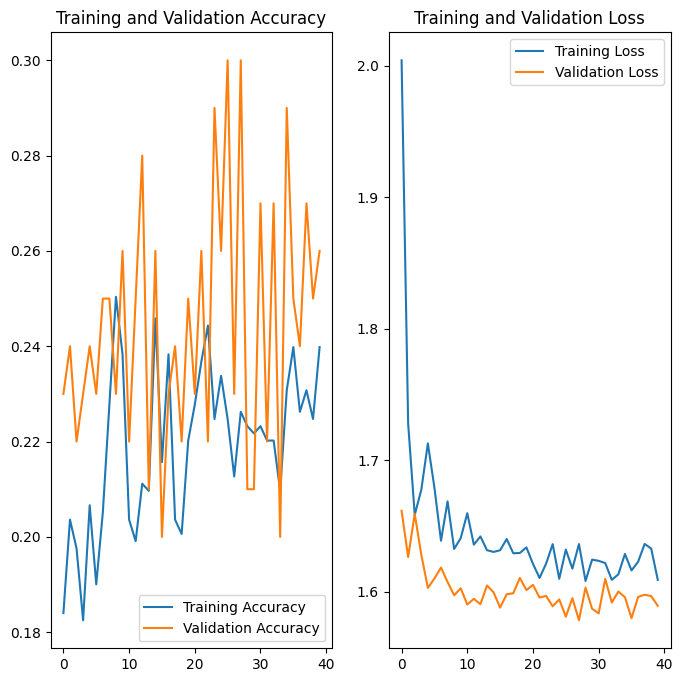

In [ ]:
plot_acc(model_17,num_epochs)

#### **Observations**

The model does not actually learn, the needing to completely update all the weights on such deep architecture may be leading to issues with vanishing gradient and thus accuracy does not truly increase. Retraining a pre-trained network is not ideal.

#### Model 18 - Transfer learning ResNet50 - 50/50

Constants
- GRU cells
-

In [ ]:
import math
resnet = ResNet50V2(weights='imagenet', include_top=False, pooling='max')
print(len(resnet.layers))

half_resnet = math.floor(len(resnet.layers)/2)

for layer in resnet.layers[:half_resnet]:
  layer.trainable = False

for layer in resnet.layers[half_resnet:]:
  layer.trainable = True

191


In [ ]:
batch_size = 5
num_epochs=40 ## updated from 25

input = Input(shape=(15,120,120,3))

layer = TimeDistributed(resnet, input_shape=(15,120,120,3))(input)

gru = GRU(64)(layer)
dropout = Dropout(0.5)(gru)
output = Dense(5, activation='softmax')(dropout)

model18 = Model(inputs=input, outputs=output)

In [ ]:
optimiser = optimizers.Adam()
model18.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print(model18.summary())

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_11 (InputLayer)       [(None, 15, 120, 120, 3)  0         
                             ]                                   
                                                                 
 time_distributed_51 (TimeDi  (None, 15, 2048)         23564800  
 stributed)                                                      
                                                                 
 gru_7 (GRU)                 (None, 64)                405888    
                                                                 
 dropout_14 (Dropout)        (None, 64)                0         
                                                                 
 dense_7 (Dense)             (None, 5)                 325       
                                                                 
Total params: 23,971,013
Trainable params: 21,756,613
Non-t

In [ ]:
img_h=120
img_w = 120
sequence_index=[i for i in range(0,30,2)]

train_generator = generator(train_path, train_doc, batch_size, img_h, img_w, sequence_index)
val_generator = generator(val_path, val_doc, batch_size, img_h, img_w, sequence_index)

In [ ]:
model_name = 'resnet50v2_half_trainable_' + str(curr_dt_time).replace('-','')

if not os.path.exists(model_name):

    os.mkdir(model_name)

filepath = model_name +"/" + model_name + '.h5'

checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True, save_weights_only=False, mode='auto')

LR = ReduceLROnPlateau(monitor = 'val_loss',
                      factor=0.3,
                      patience=3,
                      verbose=1)
callbacks_list = [checkpoint, LR]

In [ ]:
if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1

In [ ]:
model_18 = model18.fit(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1,
                    callbacks=callbacks_list, validation_data=val_generator,
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

Source path =  /content/Project_data/train ; batch size = 5
Epoch 1/40
133/133 [==============================] - ETA: 0s - loss: 2.0206 - categorical_accuracy: 0.2202Source path =  /content/Project_data/val ; batch size = 5

Epoch 1: val_loss improved from inf to 1.65821, saving model to resnet50v2_half_trainable_20230806/resnet50v2_half_trainable_20230806.h5
133/133 [==============================] - 121s 863ms/step - loss: 2.0206 - categorical_accuracy: 0.2202 - val_loss: 1.6582 - val_categorical_accuracy: 0.2000 - lr: 0.0010
Epoch 2/40
133/133 [==============================] - ETA: 0s - loss: 1.6242 - categorical_accuracy: 0.3454
Epoch 2: val_loss did not improve from 1.65821
133/133 [==============================] - 112s 844ms/step - loss: 1.6242 - categorical_accuracy: 0.3454 - val_loss: 1.8548 - val_categorical_accuracy: 0.3200 - lr: 0.0010
Epoch 3/40
133/133 [==============================] - ETA: 0s - loss: 1.4268 - categorical_accuracy: 0.4178
Epoch 3: val_loss improved fro

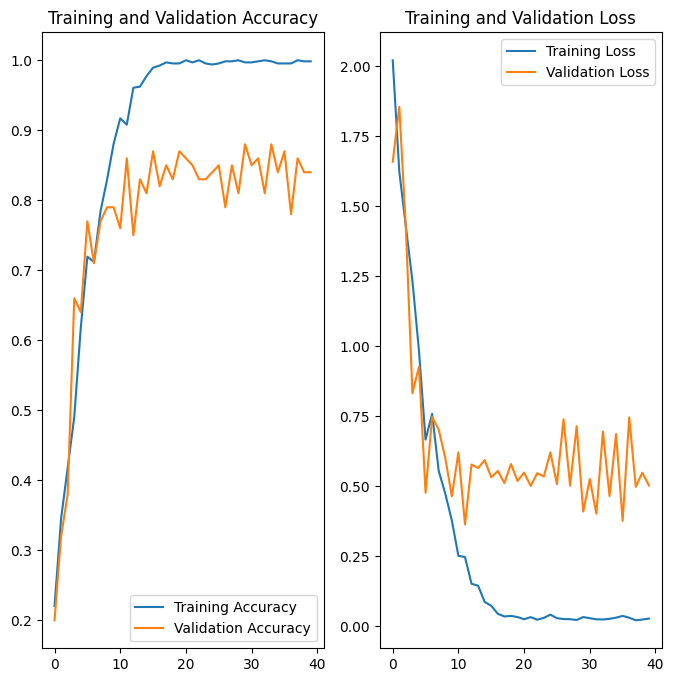

In [ ]:
plot_acc(model_18,num_epochs)

#### **Observations**

Essentially performed as well as model 15 BUt with more overfitting on the training set. Fewer layers need to be updated than just half but the performance is nonetheless admirable.